In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

In [21]:
df = pd.read_excel("pm10s_classes500m.xlsx")
df['land_use'] = df.apply(lambda row: 'Urbanizado' if row['Urbanizado'] == 1 else 'Transporte' if row['Transporte'] == 1 else 'Outros', axis=1)
df = df.drop(columns=['Urbanizado', 'Transporte'])

# Features and target
X = df[['pm10_weighted', 'land_use']]
y = df['pm10']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Preprocessing
preprocessor = ColumnTransformer(
    transformers=[('cat', OneHotEncoder(drop='first'), ['land_use'])],
    remainder='passthrough'
)

# Pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(random_state=42))
])

# Param grid with correct keys
param_grid = {
    'model__n_estimators': [100, 200, 300, 500, 750, 1000, 1500, 2000],
    'model__max_features': [1, 2]
}

# GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_root_mean_squared_error', return_train_score=True)
grid_search.fit(X_train, y_train)

# Results
print("Best parameters:", grid_search.best_params_)
print("Best RMSE:", -grid_search.best_score_)

Best parameters: {'model__max_features': 2, 'model__n_estimators': 100}
Best RMSE: 5.8146755485632395


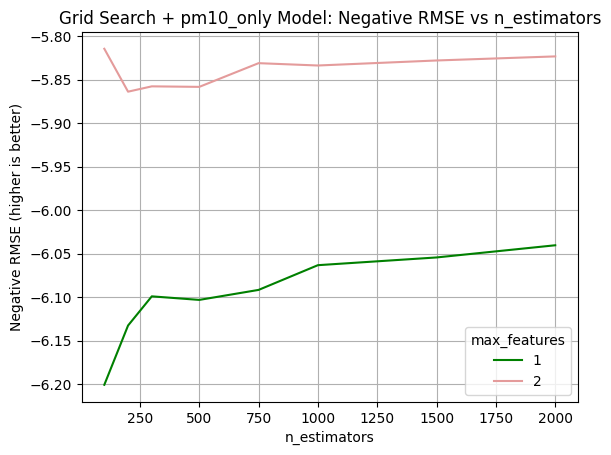

In [24]:
results = pd.DataFrame(grid_search.cv_results_)[['param_model__n_estimators', 'param_model__max_features', 'mean_test_score']]

results_plot = pd.concat([results], ignore_index=True)
results_plot['param_model__max_features'] = results_plot['param_model__max_features'].astype(str)

# Custom color palette
palette = {
    '1': 'green',     
    '2': '#e49b9b',   
    '3': '#2f2f7f'
}

# Plot
sns.lineplot(
    data=results_plot,
    x='param_model__n_estimators',
    y='mean_test_score',
    hue='param_model__max_features',
    palette=palette
)


plt.title("Grid Search + pm10_only Model: Negative RMSE vs n_estimators")
plt.ylabel("Negative RMSE (higher is better)")
plt.xlabel("n_estimators")
plt.grid(True)
plt.legend(title="max_features")
plt.show()



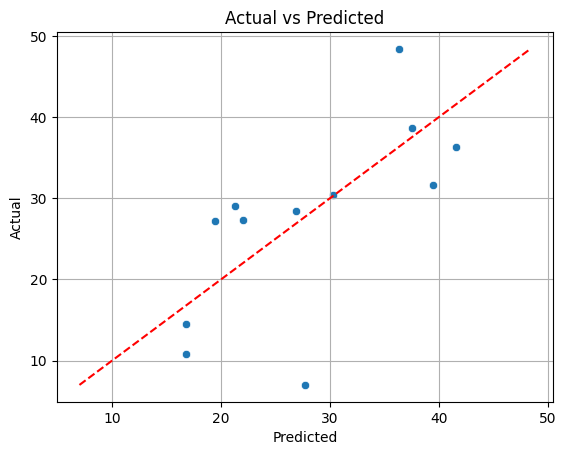

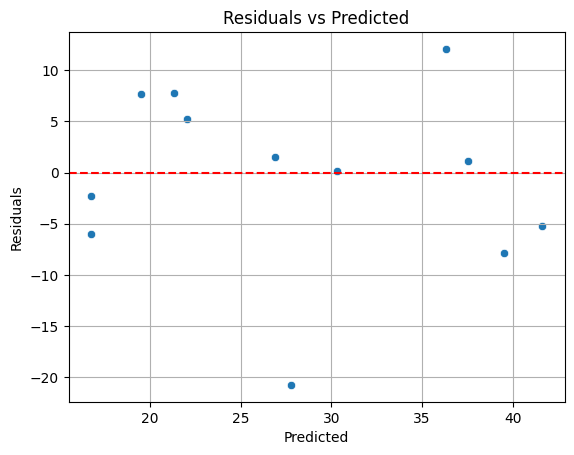

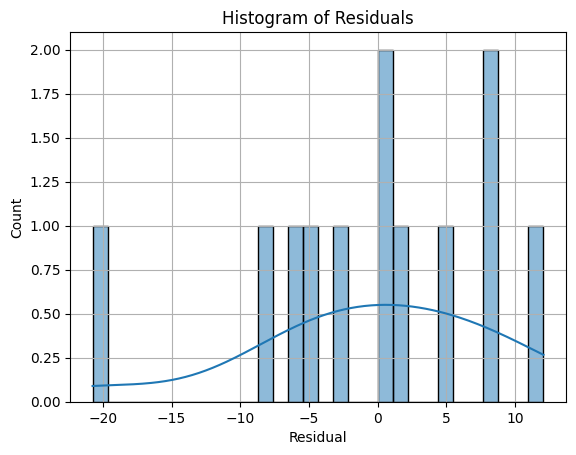

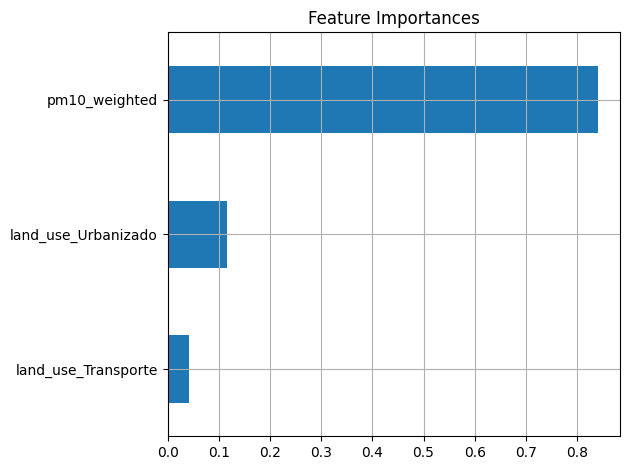

In [31]:
# Make predictions and residuals
y_pred = grid_search.predict(X_test)
residuals = y_test - y_pred
# Extract the best model and feature names from the pipeline
best_pipeline = grid_search.best_estimator_
best_rf = best_pipeline.named_steps['model']

# Get encoded feature names from OneHotEncoder
ohe = best_pipeline.named_steps['preprocessor'].named_transformers_['cat']
encoded_feature_names = ohe.get_feature_names_out(['land_use'])

# Final list of features (one-hot encoded + numeric)
feature_names = list(encoded_feature_names) + ['pm10_weighted']


# Plot: Actual vs Predicted
plt.figure()
sns.scatterplot(x=y_pred, y=y_test)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Actual vs Predicted")
plt.grid(True)
plt.show()

# Plot: Residuals vs Predicted
plt.figure()
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted")
plt.grid(True)
plt.show()

# Plot: Histogram of residuals
plt.figure()
sns.histplot(residuals, bins=30, kde=True)
plt.title("Histogram of Residuals")
plt.xlabel("Residual")
plt.grid(True)
plt.show()

# Plot: Feature importances
importances = pd.Series(best_rf.feature_importances_, index=feature_names)
importances.sort_values(ascending=True).plot(kind='barh', title="Feature Importances")
plt.grid(True)
plt.tight_layout()
plt.show()

In [33]:
from sklearn.metrics import mean_squared_error, r2_score

residuals = y_test - y_pred
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.3f}")
print(f"R²: {r2:.3f}")


print(f"RMSE: {rmse:.2f}, R²: {r2:.2f}")

RMSE: 8.458
R²: 0.442
RMSE: 8.46, R²: 0.44
